In [31]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_5_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
from funzioni import bs_sample_mean
from funzioni import bs_compute_array_mean_std_95cl
from funzioni import plot_bs_95cl_mean_std
from funzioni import bs_compute_matrix10
from funzioni import plot_bs_mean_cluster_matrix10
from funzioni import plot_bs_diff_cluster
from funzioni import compute_mean
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import random
from matplotlib.lines import Line2D

NUOVI CLUSTER: Clusterizzazione su zonal wind 850hPa

Caricamento file pickle

In [2]:
# Caricamento di models e models_atmos
with open('models_atmos_new.pkl','rb') as file:
    models_atmos = dill.load(file)
    era_na_seas_mean = dill.load(file)
    list_4_clusters_new = dill.load(file)

In [3]:
with open('models.pkl', 'rb') as file:
    models = dill.load(file)
    esa_na_seas_mean_tos = dill.load(file)
    dataset_ESA_na_celsius = dill.load(file)

Jet latitude- Jet intensity

In [4]:
for name in models_atmos.keys():
    #Seleziono la regione in cui vado a calcolare l'intensità del jet
    models_atmos[name]['atmos box jet'] = models_atmos[name]['atmos North Atlantic box']['ua'].sel(time=slice('1982-01','2014-12'),lat=slice(20,80),lon=slice(-60,0))
    #Calcolo la media climatologica nel solito periodo 1982-2014
    models_atmos[name]['atmos box jet climatology'] = compute_mean_resample_mar(models_atmos[name]['atmos box jet'] ,"1982","2014",3)

In [5]:
lat_coords = models_atmos['ACCESS-CM2']['atmos box jet climatology'].coords['lat']
n_clusters=len(list_4_clusters_new) #numero di cluster
intensity_jet_cluster_mean = [] #lista in cui vado a mettere il valore dell'intensità del jet per ogni cluster
latitude_jet_cluster_mean = [] #lista in cui vado a mettere il valore la latitudine del jet per ogni cluster
#Inizializzo xarray per la multi model mean
sum_models_intensity = 0
sum_models_latitude = 0
#CLUSTER
for n in range(n_clusters):  # ciclo su ogni cluster
    #Inizializzo xarray per la cluster mean
    sum_clusters_intensity = 0
    sum_clusters_latitude = 0
    #MODELLI
    for i in range(len(list_4_clusters_new[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_4_clusters_new[n][i] #nome modello
        #Calcolo media zonale e poi determino il massimo per ogni latitudine
        zonal_mean = models_atmos[name]['atmos box jet climatology'][0,:,:].mean(dim='lon') #0 è il plev a 850hPa            
        models_atmos[name]['jet intensity'] = zonal_mean.max() #il massimo sulla latitudine
        models_atmos[name]['jet latitude'] = (np.nanargmax(zonal_mean))*2 + models_atmos[name]['atmos box jet climatology'].lat[0] #sommo lat[0] per avere il giusto valore di latitudine, *2 perché ogni cella è di 2°
        #Somma per ogni modello per ogni longitudine, di uno specifico cluster
        sum_clusters_intensity = sum_clusters_intensity + models_atmos[name]['jet intensity']
        sum_clusters_latitude = sum_clusters_latitude + models_atmos[name]['jet latitude']
        
    #Clusters' mean per intensità e latitudine
    intensity_jet_cluster_mean.append((sum_clusters_intensity / len(list_4_clusters_new[n])))
    latitude_jet_cluster_mean.append((sum_clusters_latitude / len(list_4_clusters_new[n])))
    #Somma su tutti i modelli per la model mean    
    sum_models_intensity = sum_models_intensity + sum_clusters_intensity
    sum_models_latitude = sum_models_latitude + sum_clusters_latitude
#Multi model mean di latitudine e intensità
intensity_jet_model_mean = sum_models_intensity / len(models_atmos)
latitude_jet_model_mean = sum_models_latitude / len(models_atmos)

Jet tilt

In [6]:
#Jet tilt
lon_coords = models_atmos['ACCESS-CM2']['atmos box jet climatology'].coords['lon']
sum_models_latitude = 0
longitude_max_jet_cluster_mean = [] #longitudine a cui si ha il massimo del vento
#Inizializzo xarray
#CLUSTER
for n in range(n_clusters):  # ciclo su ogni cluster
    sum_clusters_latitude = xr.DataArray(np.zeros((len(lon_coords))), dims=['lon'], coords={'lon': lon_coords})
    #MODELLI
    for i in range(len(list_4_clusters_new[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_4_clusters_new[n][i] #nome modello
        #Inizializzazione xarray che contiene il valore della latitudine a cui si ha il massimo del vento, per ogni longitudine
        models_atmos[name]['longitude max jet'] = xr.DataArray(np.empty((len(lon_coords))), dims=['lon'], coords={'lon': lon_coords})
        #Massimo sulla latitudine, per ogni longitudine e tempo
        for j in range(len(models_atmos['ACCESS-CM2']['atmos box jet climatology'].lon)) : #ciclo sulla longitudine
            models_atmos[name]['longitude max jet'][j] = (np.nanargmax(models_atmos[name]['atmos box jet climatology'][0,:,j]))*2 + models_atmos[name]['atmos box jet climatology'].lat[0] #sommo lat[0] per avere il giusto valore di latitudine
            #Somma per ogni modello per ogni longitudine, di uno specifico cluster
            sum_clusters_latitude[j] = sum_clusters_latitude[j] + models_atmos[name]['longitude max jet'][j]
    #Clusters' mean per ogni longitudine
    latitude_jet_cluster_mean.append((sum_clusters_latitude / len(list_4_clusters_new[n])))
    #Somma su tutti i modello per ogni longitudine, per la model mean    
    sum_models_latitude = sum_models_latitude + sum_clusters_latitude
#Multi model mean per ogni longitudine
longitude_max_jet_cluster_mean = sum_models_latitude / len(models_atmos)

In [7]:
#Jet tilt linear fit --> fit lineare su tutti i valori massimi del jet per ogni longitudine, per determinare l'angolo di inclinazione
sum_model_mean = 0 #inizializzo per il calcolo del jet tilt per la model mean
jet_tilt_cluster_mean = []
for n in range(len(list_4_clusters_new)): #ciclo sui 5 cluster
    sum_cluster_mean = 0 #inizializzo per il calcolo del jet tilt per il valor medio dei cluster
    for i in range(len(list_4_clusters_new[n])): #ciclo sui modelli dei cluster
        name = list_4_clusters_new[n][i]
        fit = models_atmos[name]['longitude max jet'].polyfit(dim='lon',deg=1)
        #coefficiente angolare
        m = fit.polyfit_coefficients.sel(degree=1)
        #estraggo anngolo da coefficiente angolare
        angle_rad = np.arctan(m)
        models_atmos[name]['jet tilt'] = np.degrees(angle_rad) #array in cui vado a mettere l'angolo di inclinazione del jet per ogni modello
        #per il calcolo del jet tilt per il cluster mean
        sum_cluster_mean = sum_cluster_mean + models_atmos[name]['jet tilt']
        #per il calcolo del jet tilt per la model mean
        sum_model_mean = sum_model_mean + models_atmos[name]['jet tilt']
    jet_tilt_cluster_mean.append(sum_cluster_mean / len(list_4_clusters_new[n]))
jet_tilt_model_mean = sum_model_mean / len(models_atmos)

SST Bias DJF --> da rifare, cerca un indice con cui descrivere SST

In [8]:
#Calcolo il valor medio del bias di SST, per ogni cluster e per la multi model mean

bias_sst_cluster_mean = []
bias_sst_model_mean = []
sum_models_bias_sst = 0
for n in range(n_clusters):  # ciclo su ogni cluster
    #Inizializzo xarray per la cluster mean
    sum_clusters_bias_sst = 0
    #MODELLI
    for i in range(len(list_4_clusters_new[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_4_clusters_new[n][i] #nome modello
        models[name]['bias DJF mean'] = models[name]['North Atlantic bias DJF'].mean()
        #Somma per ogni modello di ogni cluster
        sum_clusters_bias_sst = sum_clusters_bias_sst + models[name]['bias DJF mean']
        
    #Clusters' mean
    bias_sst_cluster_mean.append((sum_clusters_bias_sst / len(list_4_clusters_new[n])))
    #Somma su tutti i modelli per la model mean    
    sum_models_bias_sst = sum_models_bias_sst + sum_clusters_bias_sst
#Multi model mean
bias_sst_model_mean = sum_models_bias_sst / len(models_atmos)

Resolution ocean module

In [9]:
#Voglio trovare la risoluzione del singolo modello per il modulo oceanico --> considero il file .nc (no remap)
for name in models.keys():
    path = models[name]['path']
    if os.path.exists(path): #Se il file esiste
        # Apro il dataset
        models[name]['dataset original'] = xr.open_dataset(path) #file .nc
        models[name]['dataset original'] = models[name]['dataset original']['tos'].sel(time=slice("1982-01", "2014-12"))
    else:
        print(f"Errore: Il file {path} non esiste per il modello {name}")

In [10]:
#Calcolo del numero dei punti griglia per ogni modello : non considero la dimensione 'time'
for name in models.keys():
    if len(models[name]['dataset original'].shape) == 2: #cioè soltanto un'altra dimensione oltre a 'time'. In questo caso considero soltanto i due modelli AI, che hanno griglia unstructured
        models[name]['number of grid points'] = (models[name]['dataset original'].shape)[1] #cioè il numero di punti griglia è pari alla seconda dimensione, non considero 'time'
    else:
        dataset = models[name]['dataset original'] #non considero la dimensione 'time'
        #Numero totale dei punti griglia
        models[name]['number of grid points'] = ((dataset.values)).shape[1] * ((dataset.values)).shape[2] #1,2 perché non voglio la coordianta 'time' che è la 0
        #Tolgo i nan
        #Per il modello 'E3SM-1-0' si hanno valori 1. sulla land, li sostituisco quindi con 'nan' per poi togliere tutti i nan
        if name == 'E3SM-1-0':
            models[name]['dataset original'] = xr.where(models[name]['dataset original'] == 1.,np.nan,models[name]['dataset original'])
        n_nan = np.isnan(dataset[0].values).sum() #non considero la dimensione tempo
        models[name]['number of grid points'] = models[name]['number of grid points'] - n_nan
        if name == 'E3SM-1-0' or name == 'GISS-E2-1-G' or name == 'GISS-E2-1-G-CC' or name =='GISS-E2-1-H' or name == 'CESM2-WACCM':
            print(name,models[name]['number of grid points'])

E3SM-1-0 64287
GISS-E2-1-G 8945
GISS-E2-1-G-CC 8945
GISS-E2-1-H 9329
CESM2-WACCM 42491


In [11]:
#Calcolo della risoluzione per ogni modello: area superficie oceanica diviso il numero di punti griglia, tutto sotto radice quadrata
#Superficie oceanica = 360 700 000 km^2
sup_ocean = 360700000 #km^2
#calcolo la risoluzione per ogni cluster e per la multi model mean
ocean_res_cluster_mean = []
ocean_res_model_mean = []
sum_models_ocean_res = 0
for n in range(n_clusters):  # ciclo su ogni cluster
    #Inizializzo xarray per la cluster mean
    sum_clusters_ocean_res = 0
    #MODELLI
    for i in range(len(list_4_clusters_new[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_4_clusters_new[n][i] #nome modello
        models[name]['model resolution'] = np.sqrt(sup_ocean / models[name]['number of grid points'])
        #Somma per ogni modello di ogni cluster
        sum_clusters_ocean_res = sum_clusters_ocean_res + models[name]['model resolution']
        
    #Clusters' mean
    ocean_res_cluster_mean.append((sum_clusters_ocean_res / len(list_4_clusters_new[n])))
    #Somma su tutti i modelli per la model mean    
    sum_models_ocean_res = sum_models_ocean_res + sum_clusters_ocean_res
#Multi model mean
ocean_res_model_mean = sum_models_ocean_res / len(models)

Root mean square error - ocean

In [12]:
#calcolo il Root mean square error (rmse) del bias di SST nella regione del Nord Atlantico, per ogni modello
#calcolo la risoluzione per ogni cluster e per la multi model mean
ocean_rmse_cluster_mean = []
ocean_rmse_model_mean = []
sum_models_ocean_rmse = 0
for n in range(n_clusters):  # ciclo su ogni cluster
    #Inizializzo xarray per la cluster mean
    sum_clusters_ocean_rmse = 0
    #MODELLI
    for i in range(len(list_4_clusters_new[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_4_clusters_new[n][i] #nome modello
        sum_bias = 0 #per ogni nuovo modello
        sum_bias = np.sum(models[name]['North Atlantic bias DJF'])
        models[name]['rms error'] = np.sqrt((1/models[name]['number of grid points'])*(sum_bias**2)) #rmse per ogni modello, vedo quanto ogni modello fa bene
        #Somma per ogni modello di ogni cluster
        sum_clusters_ocean_rmse = sum_clusters_ocean_rmse + models[name]['rms error']
        
    #Clusters' mean
    ocean_rmse_cluster_mean.append((sum_clusters_ocean_rmse / len(list_4_clusters_new[n])))
    #Somma su tutti i modelli per la model mean    
    sum_models_ocean_rmse = sum_models_ocean_rmse + sum_clusters_ocean_rmse
#Multi model mean
ocean_rmse_model_mean = sum_models_ocean_rmse / len(models)

In [13]:
#risoluzione dei modelli come visto dal report IPCC: the area of the ocean surface divided by the number of surface ocean grid points
#La risoluzione è in km
resol_ipcc = [60,20,50,80,80,90,80,80,70,70,70,70,40,70,70,60,100,70,80,40,100,60,100,100,70,60,60,60,60,60,60,40,70,60,190]
k = 0 #indice dell'array resol_ipcc
for name in models.keys():
    models[name]['model resolution ipcc'] = resol_ipcc[k]
    k = k + 1

Resolution atmosphere module

In [14]:
#Voglio trovare la risoluzione del singolo modello per il modulo oceanico --> considero il file .nc (no remap)
for name in models_atmos.keys():
    path = models_atmos[name]['atmos path']
    if os.path.exists(path): #Se il file esiste
        # Apro il dataset
        models_atmos[name]['atmos dataset original'] = xr.open_dataset(path) #file .nc
        models_atmos[name]['atmos dataset original'] = models_atmos[name]['atmos dataset original']['ua'].sel(time=slice("1982-01", "2014-12"))
    else:
        print(f"Errore: Il file {path} non esiste per il modello {name}")

In [15]:
#Numero di punti griglia e risoluzione modulo atmosferico
#Area superficie terrestre = 360 700 000 km^2
sup_earth = 510100000 #km^2
for name in models_atmos.keys():
    #Calcolo del numero dei punti griglia per ogni modello : non considero la dimensione 'time' e 'plev':
    models_atmos[name]['atmos number of grid points'] = (models_atmos[name]['atmos dataset original'].shape)[2] * (models_atmos[name]['atmos dataset original'].shape)[3] #1,2 perché non voglio la coordianta 'time' che è la 0
    #Tolgo i nan
    dataset = models_atmos[name]['atmos dataset original']
    n_nan = np.isnan(dataset[0].values).sum() #non considero la dimensione tempo

In [16]:
#calcolo la risoluzione per ogni cluster e per la multi model mean
atmos_res_cluster_mean = []
atmos_res_model_mean = []
sum_models_atmos_res = 0
for n in range(n_clusters):  # ciclo su ogni cluster
    #Inizializzo xarray per la cluster mean
    sum_clusters_atmos_res = 0
    #MODELLI
    for i in range(len(list_4_clusters_new[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_4_clusters_new[n][i] #nome modello    
        #Calcolo della risoluzione per ogni modello: area superficie terrestre diviso il numero di punti griglia, tutto sotto radice quadrata
        models_atmos[name]['atmos model resolution'] = np.sqrt(sup_earth / models_atmos[name]['atmos number of grid points'])
        #Somma per ogni modello di ogni cluster
        sum_clusters_atmos_res = sum_clusters_atmos_res + models_atmos[name]['atmos model resolution']
        
    #Clusters' mean
    atmos_res_cluster_mean.append((sum_clusters_atmos_res / len(list_4_clusters_new[n])))
    #Somma su tutti i modelli per la model mean    
    sum_models_atmos_res = sum_models_atmos_res + sum_clusters_atmos_res
#Multi model mean
atmos_res_model_mean = sum_models_atmos_res / len(models_atmos)

Root mean square error - atmosphere

In [17]:
#calcolo il Root mean square error (rmse) del bias di SST nella regione del Nord Atlantico, per ogni modello
#calcolo la risoluzione per ogni cluster e per la multi model mean
atmos_rmse_cluster_mean = []
atmos_rmse_model_mean = []
sum_models_atmos_rmse = 0
for n in range(n_clusters):  # ciclo su ogni cluster
    #Inizializzo xarray per la cluster mean
    sum_clusters_atmos_rmse = 0
    #MODELLI
    for i in range(len(list_4_clusters_new[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_4_clusters_new[n][i] #nome modello
        sum_bias = 0 #per ogni nuovo modello
        sum_bias = np.sum(models_atmos[name]['atmos North Atlantic bias DJF'])
        models_atmos[name]['atmos rms error'] = np.sqrt((1/models_atmos[name]['atmos number of grid points'])*(sum_bias**2)) #rmse per ogni modello, vedo quanto ogni modello fa bene
        #Somma per ogni modello di ogni cluster
        sum_clusters_atmos_rmse = sum_clusters_atmos_rmse + models_atmos[name]['atmos rms error']
        
    #Clusters' mean
    atmos_rmse_cluster_mean.append((sum_clusters_atmos_rmse / len(list_4_clusters_new[n])))
    #Somma su tutti i modelli per la model mean    
    sum_models_atmos_rmse = sum_models_atmos_rmse + sum_clusters_atmos_rmse
#Multi model mean
atmos_rmse_model_mean = sum_models_atmos_rmse / len(models_atmos)

In [18]:
#risoluzione dei modelli come visto dal report IPCC: the area of the earth surface divided by the number of grid points
#La risoluzione è in km
# CAS-ESM2-0 ?
resol_atmos_ipcc = [100,80,170,100,250,100,120,190,250,100,140,140,100,80,80,100,170,160,250,80,170,100,200,200,200,100,100,100,100,190,100,100,170,100,260]
k = 0 #indice dell'array resol_ipcc
for name in models_atmos.keys():
    models_atmos[name]['atmos model resolution ipcc'] = resol_atmos_ipcc[k]
    k = k + 1

Gulf Stream: latitude, intensity, tilt (calcolati sul gradiente!)

In [19]:
#Calcolo la latitudine/intensità della Gulf Stream
intensity_gs_cluster_mean = [] #lista in cui vado a mettere il valore dell'intensità della gs per ogni cluster
latitude_gs_cluster_mean = [] #lista in cui vado a mettere il valore la latitudine della gs per ogni cluster
#Inizializzo xarray per la multi model mean
sum_models_intensity = 0
sum_models_latitude = 0
#CLUSTER
for n in range(n_clusters):  # ciclo su ogni cluster
    #Inizializzo xarray per la cluster mean
    sum_clusters_intensity = 0
    sum_clusters_latitude = 0
    #MODELLI
    for i in range(len(list_4_clusters_new[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_4_clusters_new[n][i] #nome modello
        #Calcolo il gradiente e poi la media zonale e poi determino il massimo per ogni latitudine
        gradient = np.gradient(models[name]['GS box seas mean DJF'],axis=1)
        gradient = xr.DataArray(gradient, dims=['lat', 'lon'], coords={'lat': models[name]['GS box seas mean DJF'].lat, 'lon': models[name]['GS box seas mean DJF'].lon})
        zonal_mean = gradient.mean(dim='lon') #0 è il plev a 850hPa         
        models[name]['gs intensity'] = zonal_mean.max() #il massimo sulla latitudine
        models[name]['gs latitude'] = (np.nanargmax(zonal_mean))*2 + models[name]['GS box seas mean DJF'].lat[0] #sommo lat[0] per avere il giusto valore di latitudine, *2 perché ogni cella è di 2°
        #print(name,models[name]['gs intensity'].values,models[name]['gs latitude'].values)
        #Somma per ogni modello per ogni longitudine, di uno specifico cluster
        sum_clusters_intensity = sum_clusters_intensity + models[name]['gs intensity']
        sum_clusters_latitude = sum_clusters_latitude + models[name]['gs latitude']
        
    #Clusters' mean per intensità e latitudine
    intensity_gs_cluster_mean.append((sum_clusters_intensity / len(list_4_clusters_new[n])))
    latitude_gs_cluster_mean.append((sum_clusters_latitude / len(list_4_clusters_new[n])))
    #Somma su tutti i modelli per la model mean    
    sum_models_intensity = sum_models_intensity + sum_clusters_intensity
    sum_models_latitude = sum_models_latitude + sum_clusters_latitude
#Multi model mean di latitudine e intensità
intensity_gs_model_mean = sum_models_intensity / len(models_atmos)
latitude_gs_model_mean = sum_models_latitude / len(models_atmos)

In [20]:
#Calcolo il tilt della GS
sum_models_latitude = 0
longitude_max_gs_cluster_mean = [] #longitudine a cui si ha la max gs
#Inizializzo xarray
#CLUSTER
for n in range(n_clusters):  # ciclo su ogni cluster
    sum_clusters_latitude = xr.DataArray(np.zeros((len(lon_coords))), dims=['lon'], coords={'lon': lon_coords})
    #MODELLI
    for i in range(len(list_4_clusters_new[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_4_clusters_new[n][i] #nome modello
        #Inizializzazione xarray che contiene il valore della latitudine a cui si ha il massimo del vento, per ogni longitudine
        models[name]['longitude max gs'] = xr.DataArray(np.empty((len(lon_coords))), dims=['lon'], coords={'lon': lon_coords})
        #Massimo sulla latitudine, per ogni longitudine e tempo
        for j in range(len(models['ACCESS-CM2']['GS box seas mean DJF'].lon)) : #ciclo sulla longitudine
            gradient = np.gradient(models[name]['GS box seas mean DJF'],axis=1)
            gradient = xr.DataArray(gradient, dims=['lat', 'lon'], coords={'lat': models[name]['GS box seas mean DJF'].lat, 'lon': models[name]['GS box seas mean DJF'].lon})
            models[name]['longitude max gs'][j] = (np.nanargmax(gradient))*2 + models[name]['GS box seas mean DJF'].lat[0] #sommo lat[0] per avere il giusto valore di latitudine
            #Somma per ogni modello per ogni longitudine, di uno specifico cluster
            sum_clusters_latitude[j] = sum_clusters_latitude[j] + models[name]['longitude max gs'][j]
    #Clusters' mean per ogni longitudine
    latitude_gs_cluster_mean.append((sum_clusters_latitude / len(list_4_clusters_new[n])))
    #Somma su tutti i modello per ogni longitudine, per la model mean    
    sum_models_latitude = sum_models_latitude + sum_clusters_latitude
#Multi model mean per ogni longitudine
longitude_max_gs_cluster_mean = sum_models_latitude / len(models)
#Jet tilt linear fit --> fit lineare su tutti i valori massimi del jet per ogni longitudine, per determinare l'angolo di inclinazione
sum_model_mean = 0 #inizializzo per il calcolo del jet tilt per la model mean
gs_tilt_cluster_mean = []
for n in range(len(list_4_clusters_new)): #ciclo sui 5 cluster
    sum_cluster_mean = 0 #inizializzo per il calcolo del jet tilt per il valor medio dei cluster
    for i in range(len(list_4_clusters_new[n])): #ciclo sui modelli dei cluster
        name = list_4_clusters_new[n][i]
        fit = models[name]['longitude max gs'].polyfit(dim='lon',deg=1)
        #coefficiente angolare
        m = fit.polyfit_coefficients.sel(degree=1)
        #estraggo anngolo da coefficiente angolare
        angle_rad = np.arctan(m)
        models[name]['gs tilt'] = np.degrees(angle_rad) #array in cui vado a mettere l'angolo di inclinazione del jet per ogni modello
        #per il calcolo del jet tilt per il cluster mean
        sum_cluster_mean = sum_cluster_mean + models[name]['gs tilt']
        #per il calcolo del jet tilt per la model mean
        sum_model_mean = sum_model_mean + models[name]['gs tilt']
    gs_tilt_cluster_mean.append(sum_cluster_mean / len(list_4_clusters_new[n]))
gs_tilt_model_mean = sum_model_mean / len(models)

Plot

Text(0.5, 0.98, 'Scatter plot Jet Stream Intensity - Latitude')

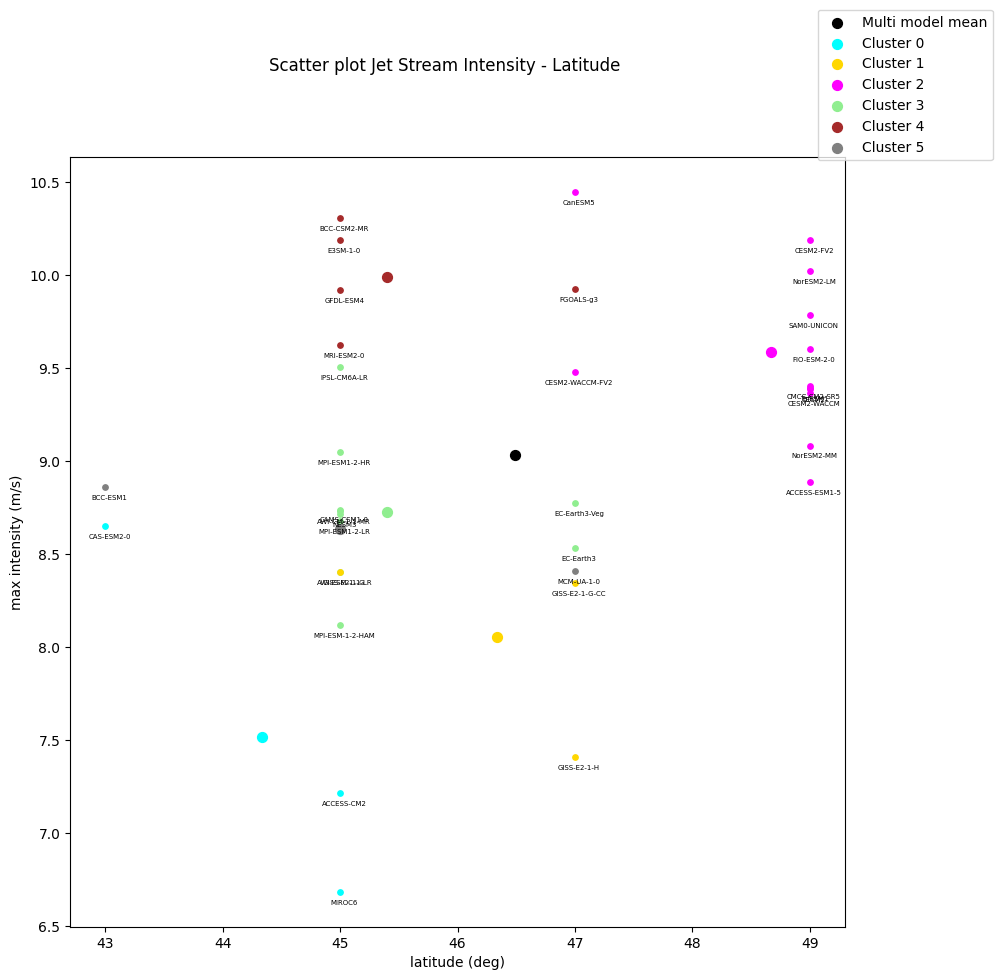

In [21]:
#Intensity-Latitude 850hPa
fig,ax = plt.subplots(figsize=(10,10))
colour_list = ['black','cyan','gold','fuchsia','lightgreen','brown','grey']
ax.scatter(latitude_jet_model_mean,intensity_jet_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_4_clusters_new)): #ciclo sui cluster
        if name in list_4_clusters_new[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['jet latitude'].values,models_atmos[name]['jet intensity'].values,s=15,color=colour_list[n+1])
            ax.annotate(name, (models_atmos[name]['jet latitude'].values,models_atmos[name]['jet intensity'].values),
                        textcoords="offset points", xytext=(3,-9), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_4_clusters_new)):
    ax.scatter(latitude_jet_cluster_mean[n],intensity_jet_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_ylabel('max intensity (m/s)')
ax.set_xlabel('latitude (deg)')
fig.suptitle('Scatter plot Jet Stream Intensity - Latitude')

Text(0.5, 0.98, 'Scatter plot Jet Stream tilt - Latitude')

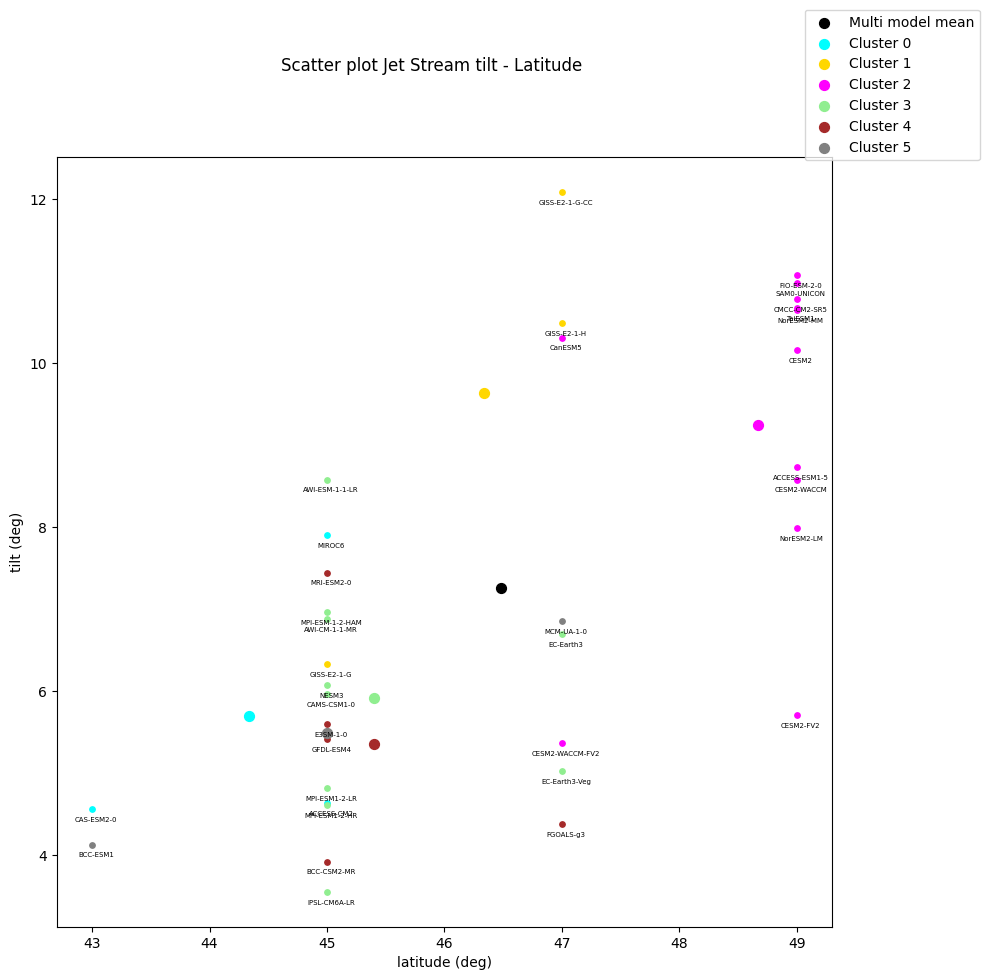

In [22]:
#Latitude - Tilt 850hPa --> ricercare una relazione lineare?
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(latitude_jet_model_mean,jet_tilt_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_4_clusters_new)): #ciclo sui cluster
        if name in list_4_clusters_new[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['jet latitude'].values,models_atmos[name]['jet tilt'].values,s=15,color=colour_list[n+1])
            ax.annotate(name, (models_atmos[name]['jet latitude'].values,
                                models_atmos[name]['jet tilt'].values),
                        textcoords="offset points", xytext=(3,-9), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_4_clusters_new)):
    ax.scatter(latitude_jet_cluster_mean[n],jet_tilt_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_xlabel('latitude (deg)')
ax.set_ylabel('tilt (deg)')
fig.suptitle('Scatter plot Jet Stream tilt - Latitude')

Text(0.5, 0.98, 'Scatter plot Ocean Resolution - Jet latitude')

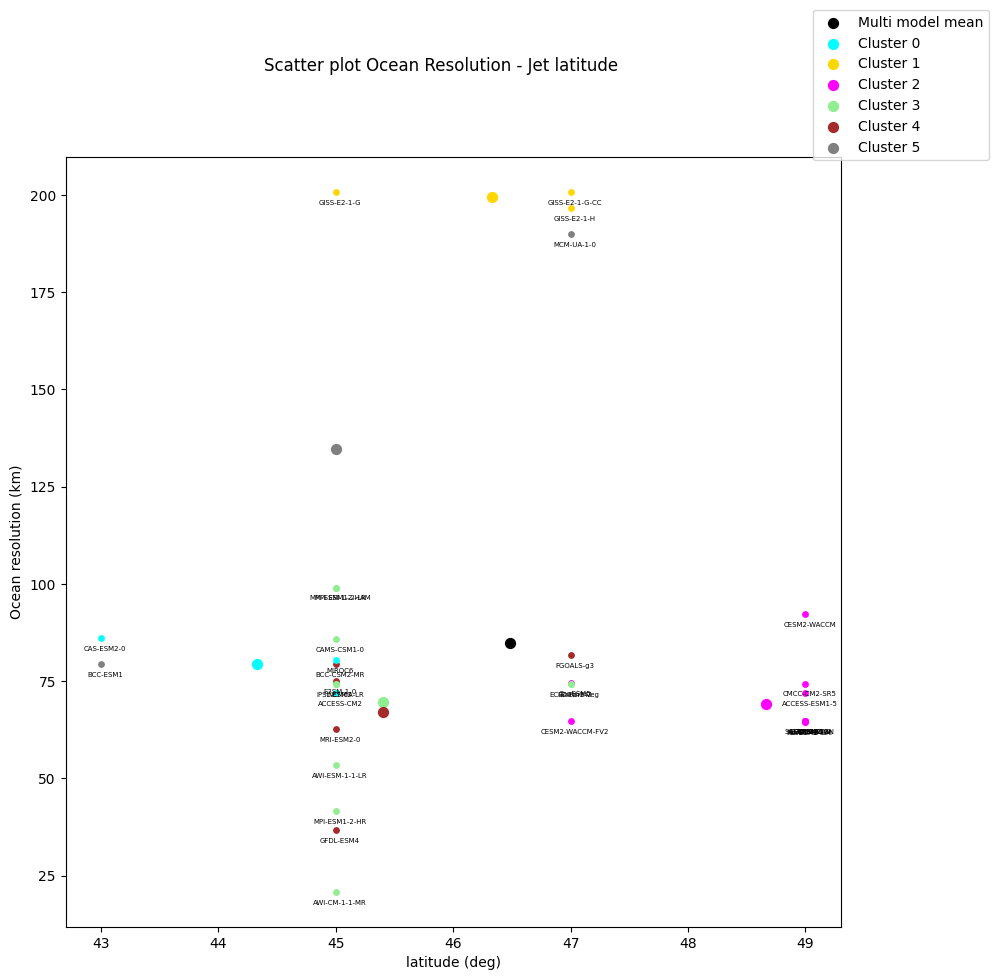

In [23]:
#Ocean resolution - Jet latitude
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(latitude_jet_model_mean,ocean_res_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_4_clusters_new)): #ciclo sui cluster
        if name in list_4_clusters_new[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['jet latitude'].values,models[name]['model resolution'],s=15,color=colour_list[n+1])
            ax.annotate(name, (models_atmos[name]['jet latitude'].values,
                                models[name]['model resolution']),
                        textcoords="offset points", xytext=(3,-9), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_4_clusters_new)):
    ax.scatter(latitude_jet_cluster_mean[n],ocean_res_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_xlabel('latitude (deg)')
ax.set_ylabel('Ocean resolution (km)')
fig.suptitle('Scatter plot Ocean Resolution - Jet latitude')

Text(0.5, 0.98, 'Scatter plot Atmosphere Resolution - Jet latitude')

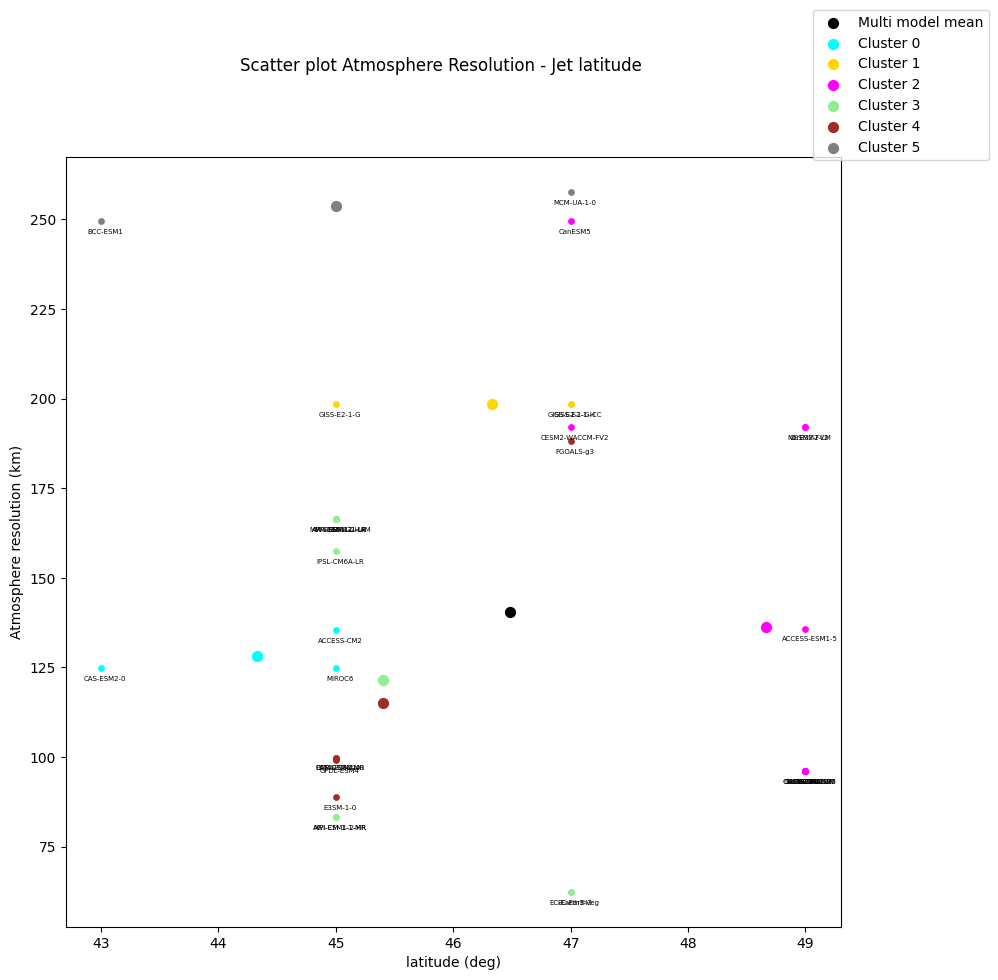

In [24]:
#Atmosphere resolution-Jet latitude
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(latitude_jet_model_mean,atmos_res_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_4_clusters_new)): #ciclo sui cluster
        if name in list_4_clusters_new[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['jet latitude'].values,models_atmos[name]['atmos model resolution'],s=15,color=colour_list[n+1])
            ax.annotate(name, (models_atmos[name]['jet latitude'].values,
                                models_atmos[name]['atmos model resolution']),
                        textcoords="offset points", xytext=(3,-9), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_4_clusters_new)):
    ax.scatter(latitude_jet_cluster_mean[n],atmos_res_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_xlabel('latitude (deg)')
ax.set_ylabel('Atmosphere resolution (km)')
fig.suptitle('Scatter plot Atmosphere Resolution - Jet latitude')

Text(0.5, 0.98, 'Scatter plot Ocean Resolution - Root mean square error')

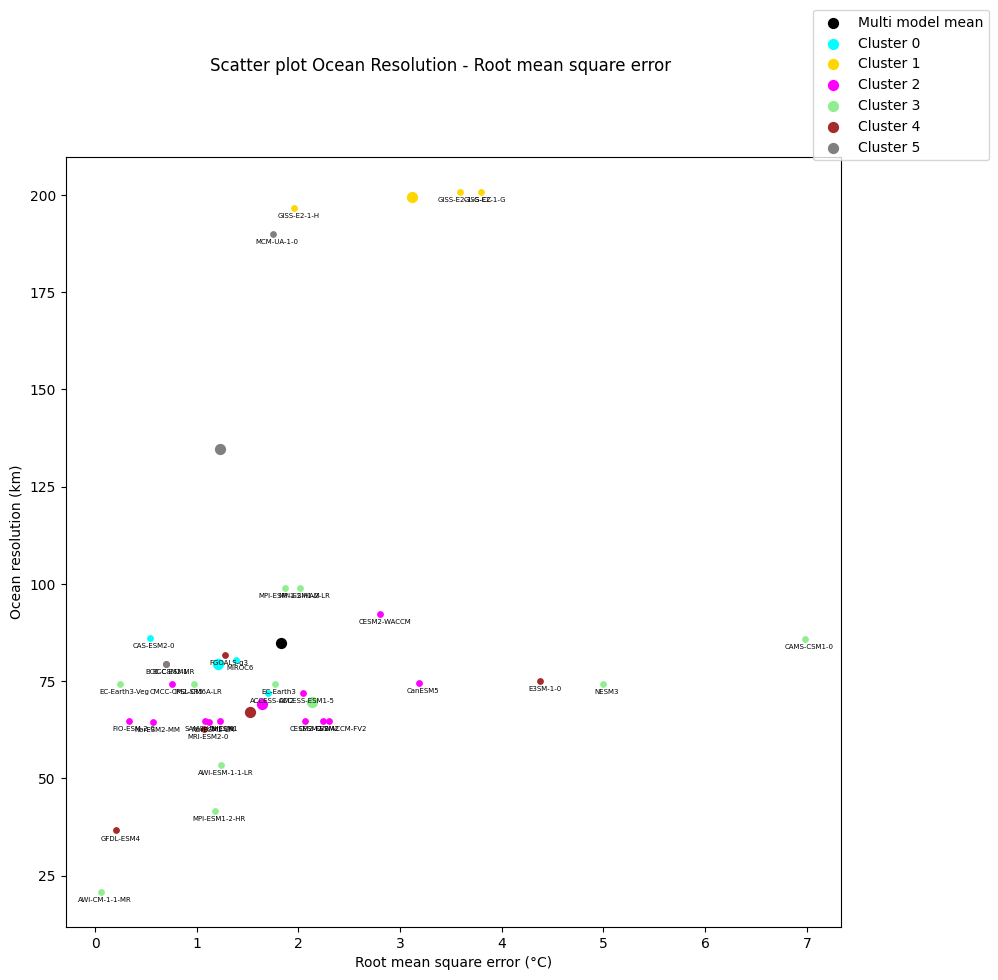

In [25]:
#Ocean resolution - RMSE Ocean
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(ocean_rmse_model_mean,ocean_res_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_4_clusters_new)): #ciclo sui cluster
        if name in list_4_clusters_new[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models[name]['rms error'].values,models[name]['model resolution'],s=15,color=colour_list[n+1])
            ax.annotate(name, (models[name]['rms error'].values,
                                models[name]['model resolution']),
                        textcoords="offset points", xytext=(3,-7), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_4_clusters_new)):
    ax.scatter(ocean_rmse_cluster_mean[n],ocean_res_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_xlabel('Root mean square error (°C)')
ax.set_ylabel('Ocean resolution (km)')
fig.suptitle('Scatter plot Ocean Resolution - Root mean square error')

Text(0.5, 0.98, 'Scatter plot Atmosphere Resolution - Root mean square error')

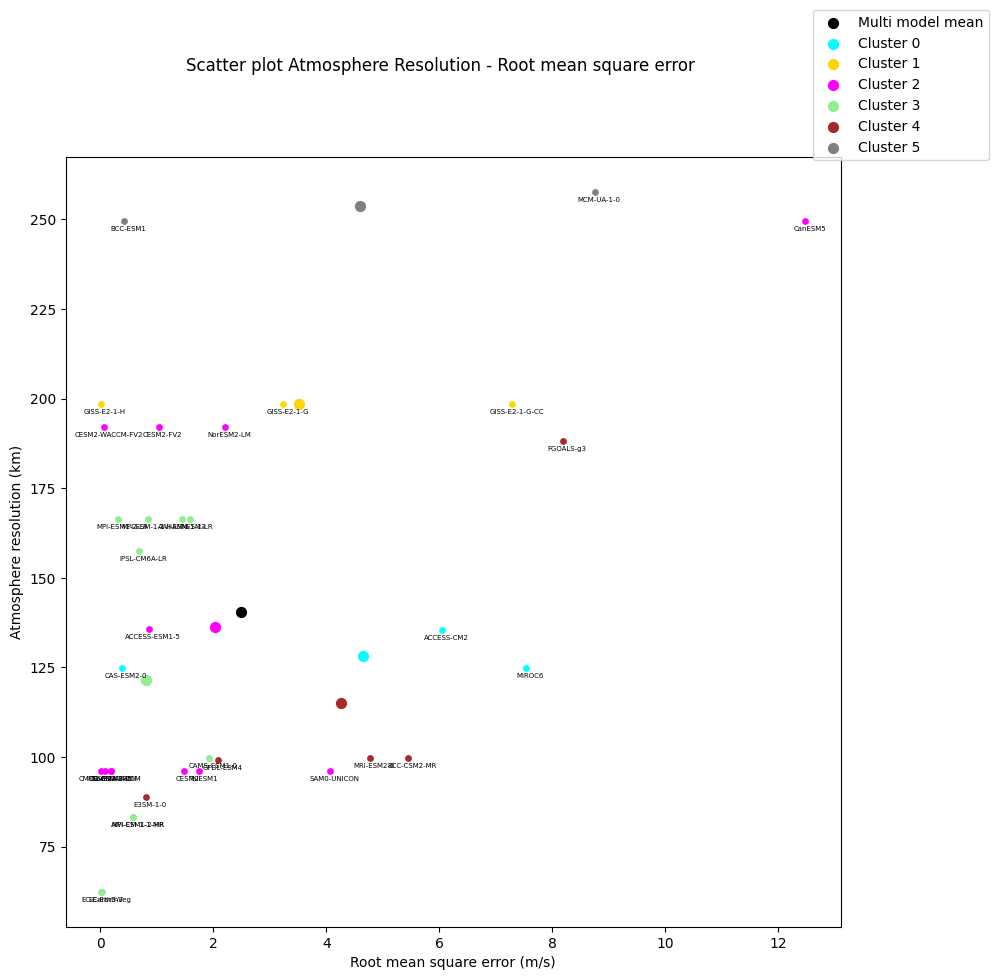

In [26]:
#Atmosphere resolution- RMSE Atmosphere
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(atmos_rmse_model_mean,atmos_res_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_4_clusters_new)): #ciclo sui cluster
        if name in list_4_clusters_new[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['atmos rms error'].values,models_atmos[name]['atmos model resolution'],s=15,color=colour_list[n+1])
            ax.annotate(name, (models_atmos[name]['atmos rms error'].values,
                                models_atmos[name]['atmos model resolution']),
                        textcoords="offset points", xytext=(3,-7), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_4_clusters_new)):
    ax.scatter(atmos_rmse_cluster_mean[n],atmos_res_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_xlabel('Root mean square error (m/s)')
ax.set_ylabel('Atmosphere resolution (km)')
fig.suptitle('Scatter plot Atmosphere Resolution - Root mean square error')

Text(0.5, 0.98, 'Scatter plot Jet Stream Latitude - Gulf Stream Intensity')

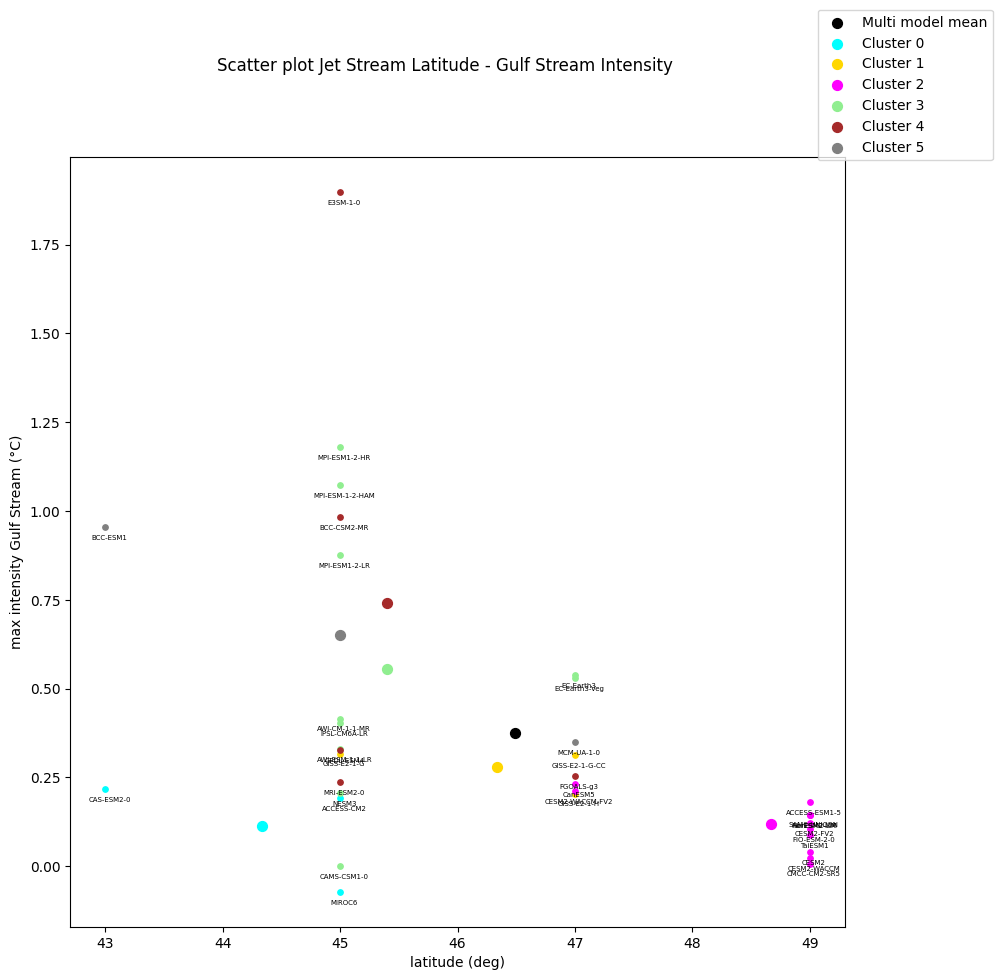

In [27]:
#GS
#Latitude jet- intensity GS
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(latitude_jet_model_mean,intensity_gs_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_4_clusters_new)): #ciclo sui cluster
        if name in list_4_clusters_new[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['jet latitude'].values,models[name]['gs intensity'].values,s=15,color=colour_list[n+1])
            ax.annotate(name, (models_atmos[name]['jet latitude'].values,models[name]['gs intensity'].values),
                        textcoords="offset points", xytext=(3,-9), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_4_clusters_new)):
    ax.scatter(latitude_jet_cluster_mean[n],intensity_gs_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_ylabel('max intensity Gulf Stream (°C)')
ax.set_xlabel('latitude (deg)')
fig.suptitle('Scatter plot Jet Stream Latitude - Gulf Stream Intensity')

Text(0.5, 0.98, 'Scatter plot Jet Stream Latitude - Gulf Stream Latitude')

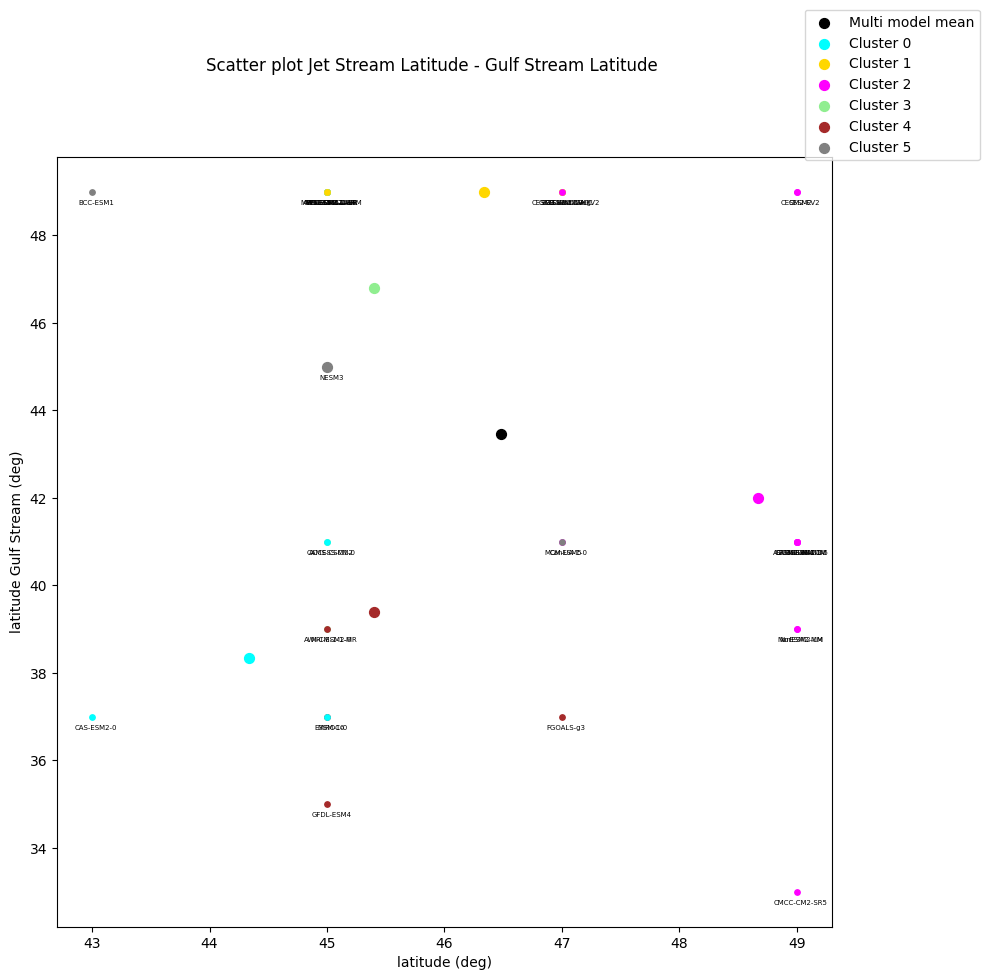

In [28]:
#GS
#Latitude jet- latitude GS
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(latitude_jet_model_mean,latitude_gs_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_4_clusters_new)): #ciclo sui cluster
        if name in list_4_clusters_new[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['jet latitude'].values,models[name]['gs latitude'].values,s=15,color=colour_list[n+1])
            ax.annotate(name, (models_atmos[name]['jet latitude'].values,models[name]['gs latitude'].values),
                        textcoords="offset points", xytext=(3,-9), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_4_clusters_new)):
    ax.scatter(latitude_jet_cluster_mean[n],latitude_gs_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_ylabel('latitude Gulf Stream (deg)')
ax.set_xlabel('latitude (deg)')
fig.suptitle('Scatter plot Jet Stream Latitude - Gulf Stream Latitude')

Text(0.5, 0.98, 'Scatter plot Jet Stream Latitude - Gulf Stream Tilt')

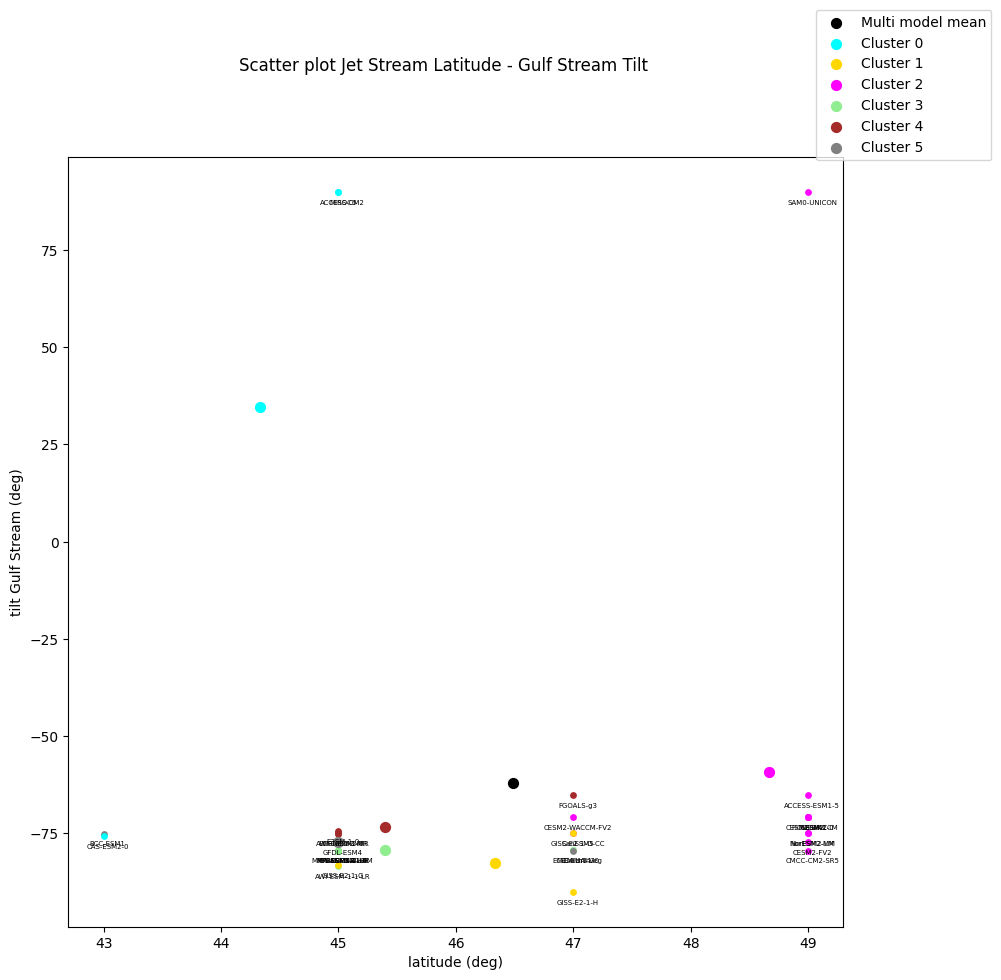

In [29]:
#GS
#Latitude jet- tilt GS
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(latitude_jet_model_mean,gs_tilt_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_4_clusters_new)): #ciclo sui cluster
        if name in list_4_clusters_new[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['jet latitude'].values,models[name]['gs tilt'].values,s=15,color=colour_list[n+1])
            ax.annotate(name, (models_atmos[name]['jet latitude'].values,models[name]['gs tilt'].values),
                        textcoords="offset points", xytext=(3,-9), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_4_clusters_new)):
    ax.scatter(latitude_jet_cluster_mean[n],gs_tilt_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_ylabel('tilt Gulf Stream (deg)')
ax.set_xlabel('latitude (deg)')
fig.suptitle('Scatter plot Jet Stream Latitude - Gulf Stream Tilt')

KeyError: 'atmos bias DJF mean'

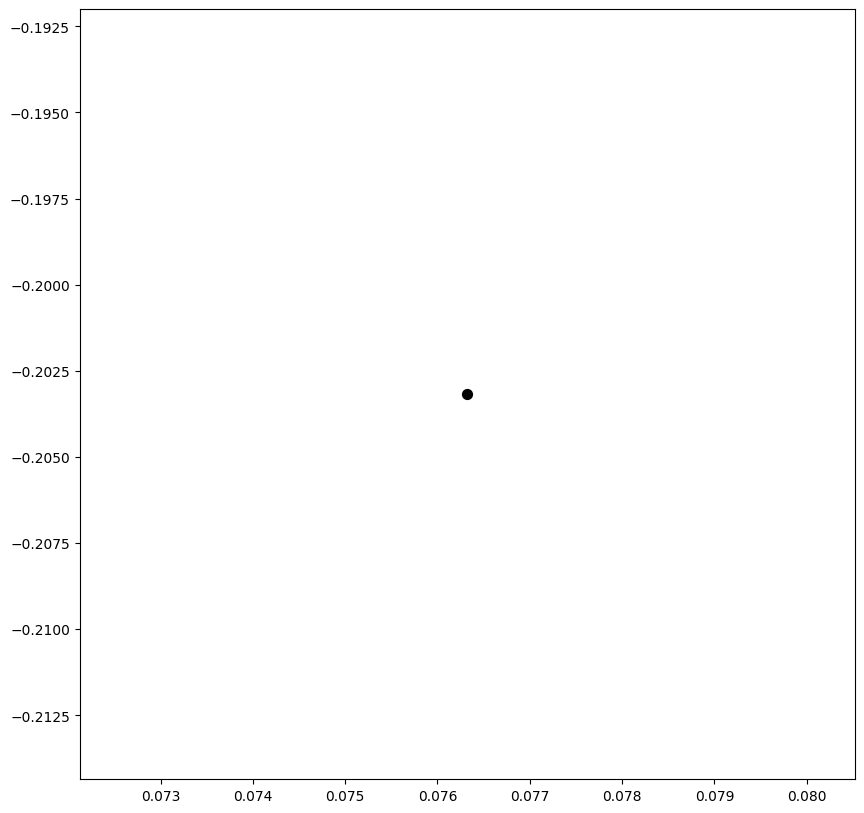

In [ ]:
#Bias SST-Bias zonal wind 850hPa --> RIFAI
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(bias_atmos_model_mean,bias_sst_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_4_clusters_new)): #ciclo sui cluster
        if name in list_4_clusters_new[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['atmos bias DJF mean'].values,models[name]['bias DJF mean'].values,s=15,color=colour_list[n+1])
            ax.annotate(name, (models_atmos[name]['atmos bias DJF mean'].values,
                                models[name]['bias DJF mean'].values),
                        textcoords="offset points", xytext=(3,-7), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_4_clusters_new)):
    ax.scatter(bias_atmos_cluster_mean[n],bias_sst_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_xlabel('bias zonal wind 850hPa (m/s)')
ax.set_ylabel('bias SST (°C)')
fig.suptitle('Scatter plot SST bias - Zonal wind bias')

Salvataggio in file pickle

In [30]:
# Caricamento di models e models_atmos
with open('models_atmos_new.pkl','wb') as file:
    dill.dump(models_atmos, file)
    dill.dump(era_na_seas_mean, file)
    dill.dump(list_4_clusters_new, file)
with open('models.pkl', 'wb') as file:
    dill.dump(models, file)
    dill.dump(esa_na_seas_mean_tos, file)
    dill.dump(dataset_ESA_na_celsius, file)